## importing the libraries and Defining functions to extract data from APIs

In [1]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

/Users/esraerdogan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Requesting main data 

In [2]:
static_json_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

# Fetch data from the static JSON URL
response = requests.get(static_json_url)
data = response.json()

# Create a DataFrame from the JSON data
df_raw = pd.json_normalize(data)

# Let's take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
df = df_raw[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are Falcon rockets with 2 extra rocket boosters 
# and rows that have multiple payloads in a single rocket.
df = df[df['cores'].map(len) == 1]
df = df[df['payloads'].map(len) == 1]

# Since payloads and cores are lists of size 1, we will also extract the single value in the list and replace the feature.
df['cores'] = df['cores'].map(lambda x: x[0])
df['payloads'] = df['payloads'].map(lambda x: x[0])

# We also want to convert the date_utc to a datetime datatype and then extract the date leaving the time
df['date'] = pd.to_datetime(df['date_utc']).dt.date

# Using the date, we will restrict the dates of the launches
df = df[df['date'] <= datetime.date(2020, 11, 13)]

df.head(1)

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24


## Requesting addition data from spacex

In [3]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

In [4]:
BoosterVersion = []
def getBoosterVersion(data):
    for x in data['rocket']:
        if x:
            response = requests.get("https://api.spacexdata.com/v4/rockets/" + str(x)).json()
            BoosterVersion.append(response['name'])
    return BoosterVersion

getBoosterVersion(df)
print(BoosterVersion[0:5])

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']


In [5]:
PayloadMass = []  
Orbit = []

def getPayloadData(data):
    for load in data['payloads']:
        try:
            if load:
                response = requests.get("https://api.spacexdata.com/v4/payloads/" + load).json()
                PayloadMass.append(response['mass_kg'])
                Orbit.append(response['orbit'])
        except Exception as e:
            print("Error occurred while processing payload data:", e)

getPayloadData(df)
print(PayloadMass[0:5],Orbit[0:5])


[20, None, 165, 200, None] ['LEO', 'LEO', 'LEO', 'LEO', 'LEO']


In [6]:
LaunchSite = []
Longitude = []
Latitude = []

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

getLaunchSite(df)
print(LaunchSite[0:5],"----", Longitude[0:5],"----",Latitude[0:5])


['Kwajalein Atoll', 'Kwajalein Atoll', 'Kwajalein Atoll', 'Kwajalein Atoll', 'CCSFS SLC 40'] ---- [167.7431292, 167.7431292, 167.7431292, 167.7431292, -80.577366] ---- [9.0477206, 9.0477206, 9.0477206, 9.0477206, 28.5618571]


In [7]:
Block = []
ReusedCount = []
Serial = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

getCoreData(df)
print(LaunchSite[0:5],"----", 
      Longitude[0:5],"----",
      Latitude[0:5],
      Block[0:5],"----",
      ReusedCount[0:5],"----",
      Serial[0:5],"----",
      Outcome[0:5],"----",
      Flights[0:5],"----",
      GridFins[0:5],"----",
      Reused[0:5],"----",
      Legs[0:5],"----",
      LandingPad[0:5],"----")


['Kwajalein Atoll', 'Kwajalein Atoll', 'Kwajalein Atoll', 'Kwajalein Atoll', 'CCSFS SLC 40'] ---- [167.7431292, 167.7431292, 167.7431292, 167.7431292, -80.577366] ---- [9.0477206, 9.0477206, 9.0477206, 9.0477206, 28.5618571] [None, None, None, None, 1] ---- [0, 0, 0, 0, 0] ---- ['Merlin1A', 'Merlin2A', 'Merlin2C', 'Merlin3C', 'B0003'] ---- ['None None', 'None None', 'None None', 'None None', 'None None'] ---- [1, 1, 1, 1, 1] ---- [False, False, False, False, False] ---- [False, False, False, False, False] ---- [False, False, False, False, False] ---- [None, None, None, None, None] ----


## combining two data to construct a dataset

In [8]:
launch_dict = {'FlightNumber': list(df['flight_number']),
'Date': list(df['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [9]:
launch_df = pd.DataFrame(launch_dict)
launch_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [10]:
#Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches.
df_falcon9 = launch_df[launch_df['BoosterVersion'] == 'Falcon 9']
df_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [12]:
#Now that we have removed some values we should reset the FlgihtNumber column
df_falcon9.loc[:,'FlightNumber'] = list(range(1, df_falcon9.shape[0]+1))
df_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


## Data Wrangling

In [13]:
df_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [14]:
payload_mass_mean = df_falcon9['PayloadMass'].mean()

# Replace NaN values with the mean
df_falcon9['PayloadMass'].replace(np.nan, payload_mass_mean, inplace=True)
df_falcon9.isnull().sum()

/var/folders/bt/d2nt51711wd5wyq7pc71b47w0000gn/T/ipykernel_11321/3267275030.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_falcon9['PayloadMass'].replace(np.nan, payload_mass_mean, inplace=True)
/var/folders/bt/d2nt51711wd5wyq7pc71b47w0000gn/T/ipykernel_11321/3267275030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_falcon9['Pa

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

## saving data to a csv file

In [15]:
df_falcon9.to_csv('dataset_1.csv', index=False)

#### In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed on a drone ship False ASDS means the mission outcome was unsuccessfully landed on a drone ship.

In [91]:
df=pd.read_csv("dataset_1.csv")
df.tail()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
85,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
86,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
87,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
88,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857
89,90,2020-11-05,Falcon 9,3681.0,MEO,CCSFS SLC 40,True ASDS,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,8,B1062,-80.577366,28.561857


In [92]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [93]:
missing_perc=df.isnull().sum()/len(df)*100
missing_perc

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [94]:
df['LaunchSite'].value_counts()

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

### 

LEO: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth),[1] or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.[2] Most of the manmade objects in outer space are in LEO [1].

VLEO: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation[2].

GTO A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website [3] .

SSO (or SO): It is a Sun-synchronous orbit also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time [4] .

ES-L1 :At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth [5] .

HEO A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth [6].

ISS A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada) [7]

MEO Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours [8]

HEO Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi) [9]

GEO It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation [10]

PO It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth [11]

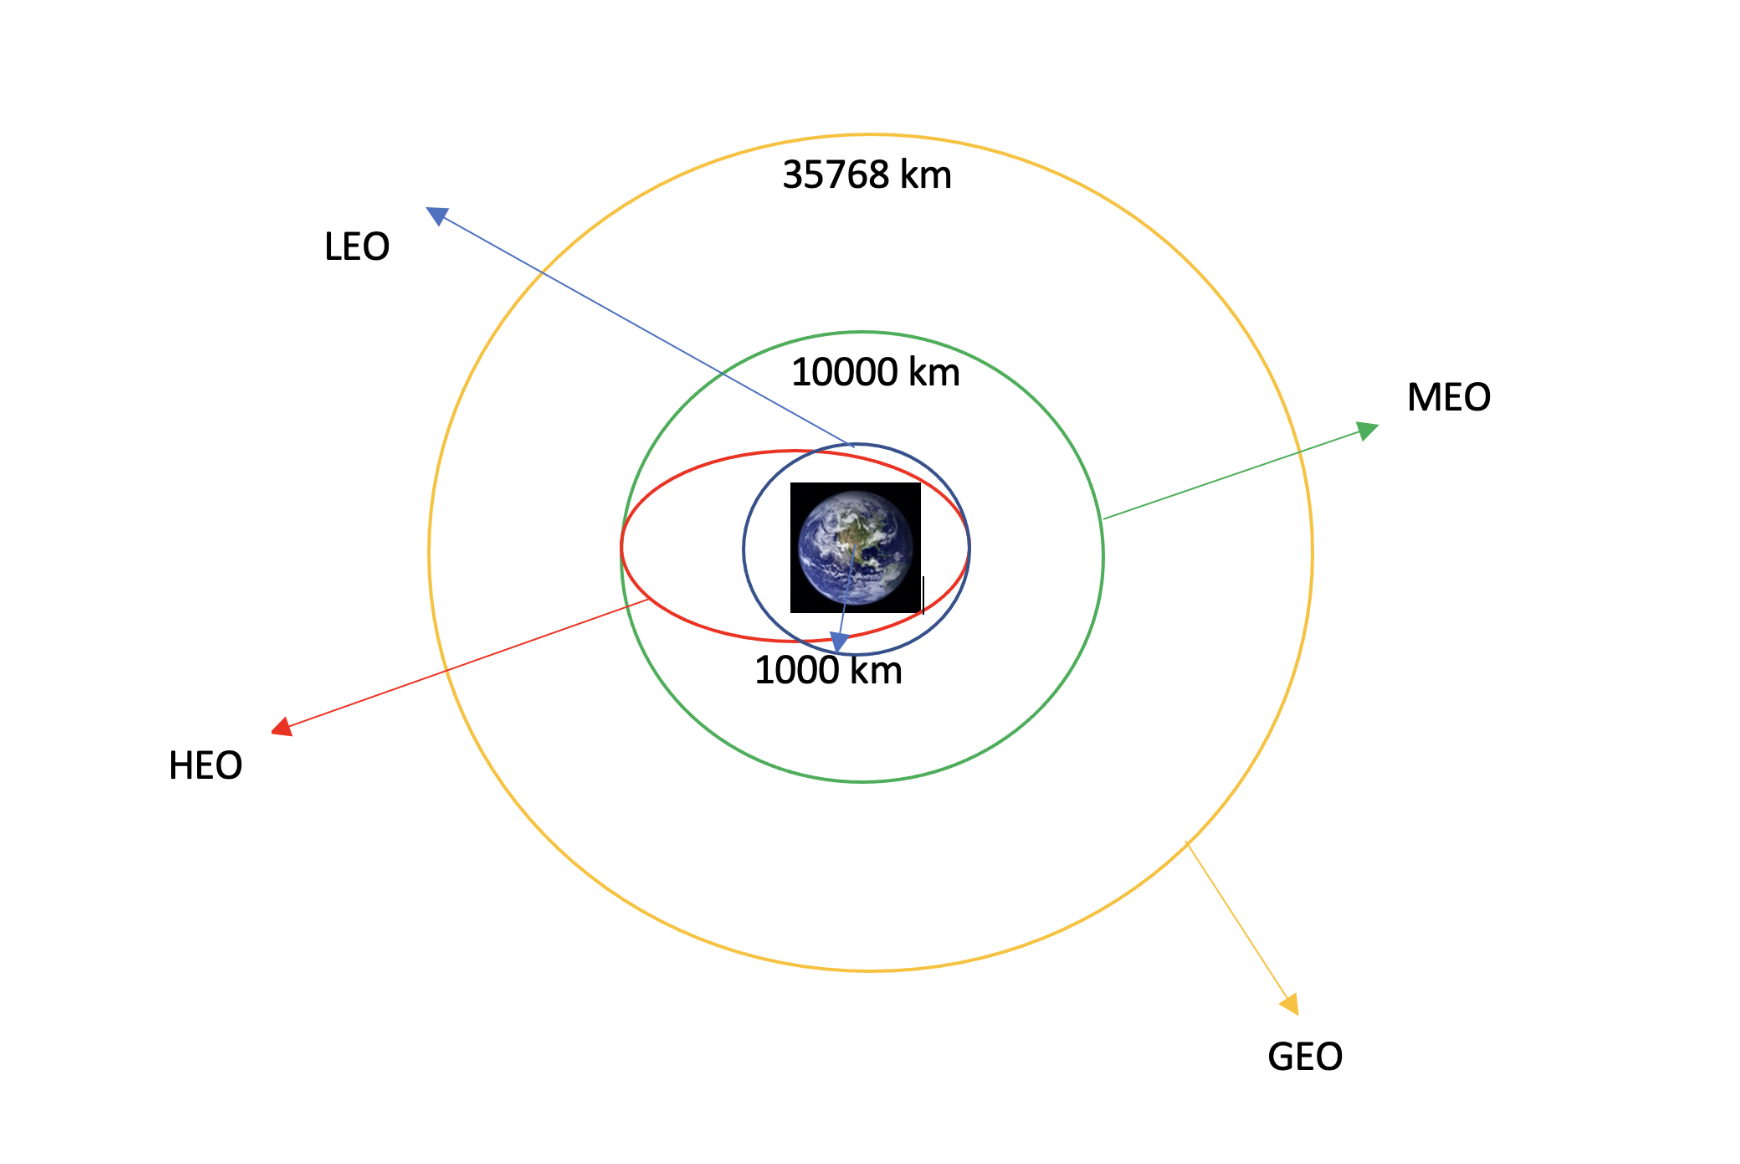

In [95]:
from IPython.display import Image
Image('Screenshot 2024-03-22 at 10.27.49 AM.png')

In [96]:
df['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64

In [97]:
landing_outcomes=df['Outcome'].value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

##### True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed to a drone ship False ASDS means the mission outcome was unsuccessfully landed to a drone ship. None ASDS and None None these represent a failure to land.

In [98]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [99]:
bad_outcome=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcome

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [100]:
landing_class = [0 if outcome in bad_outcome else 1 for outcome in df['Outcome']]

df['Class']=landing_class
df[['Class']].head()

,Class
0,0
1,0
2,0
3,0
4,0


In [101]:
df.tail(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
85,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058,1
86,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058,1
87,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058,1
88,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857,1
89,90,2020-11-05,Falcon 9,3681.0,MEO,CCSFS SLC 40,True ASDS,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,8,B1062,-80.577366,28.561857,1


In [102]:
success_rate=df["Class"].mean()
success_rate

0.6666666666666666

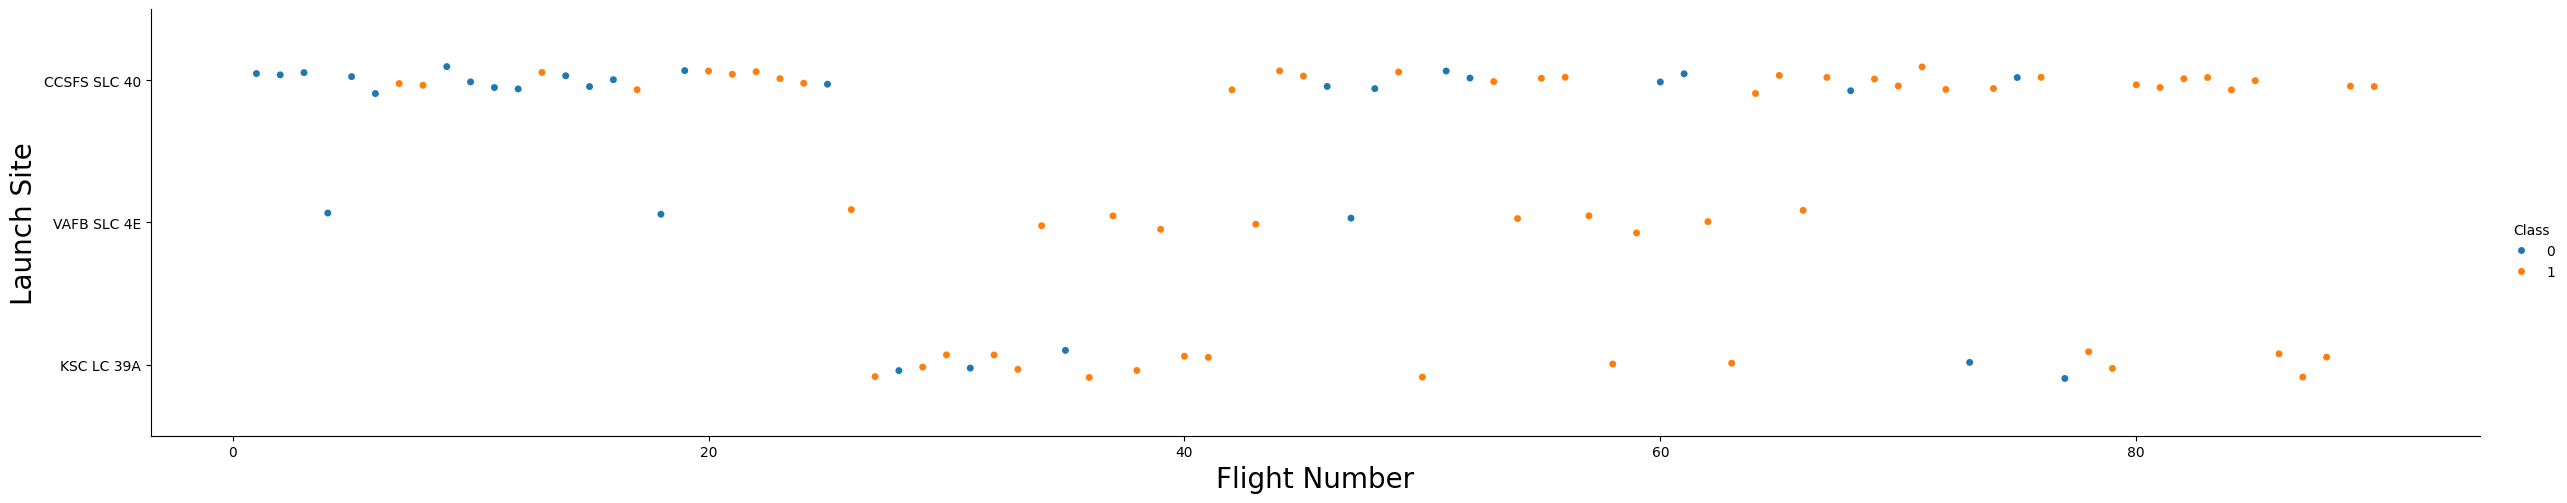

In [103]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show();

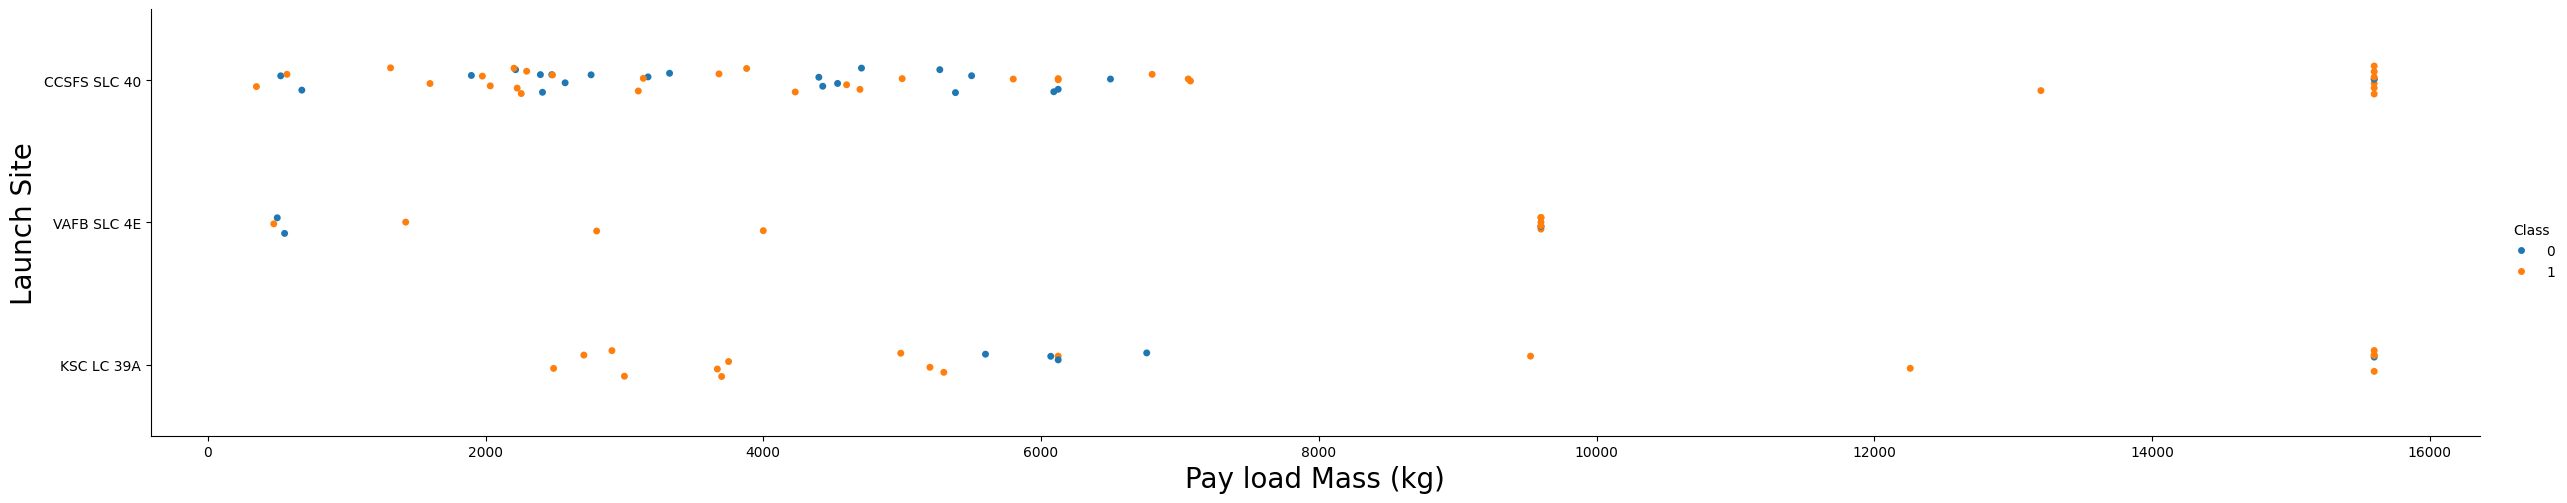

In [104]:
sns.catplot(x="PayloadMass", y="LaunchSite", hue="Class", data=df, aspect = 5)
plt.ylabel("Launch Site",fontsize=20)
plt.xlabel("Pay load Mass (kg)",fontsize=20)
plt.show()

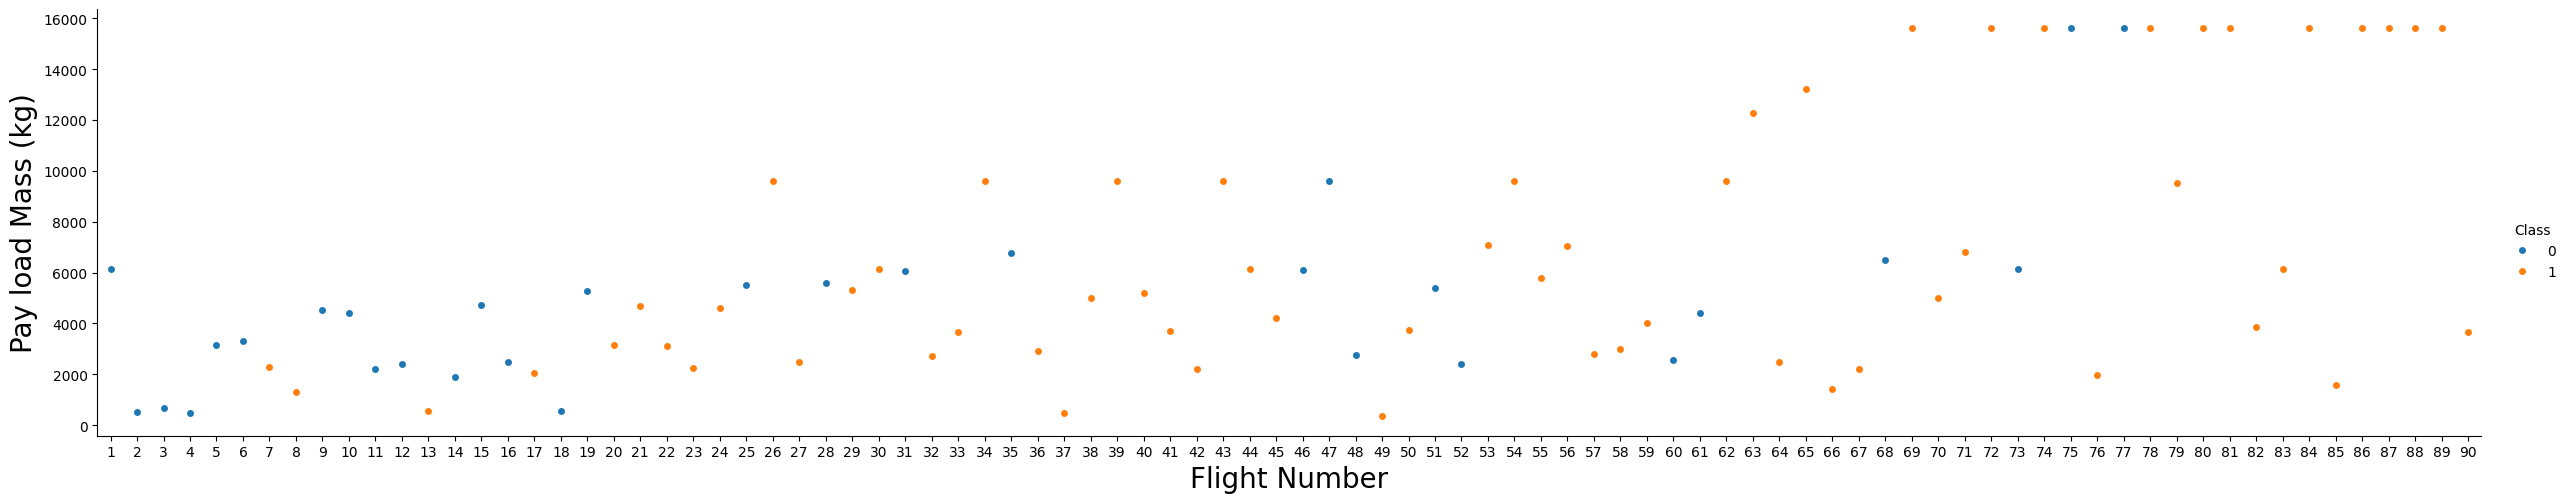

In [105]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

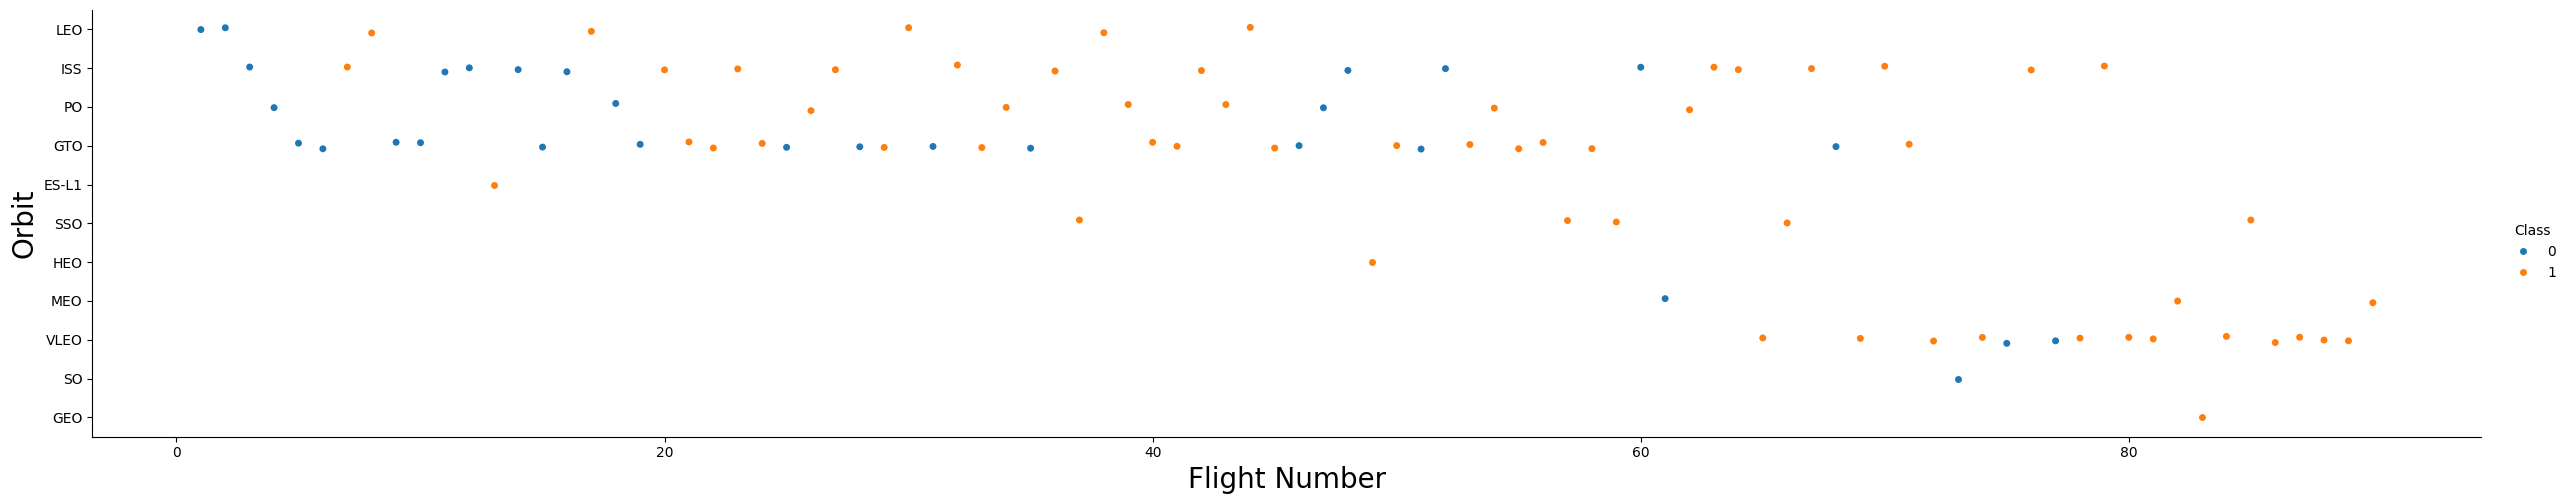

In [106]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

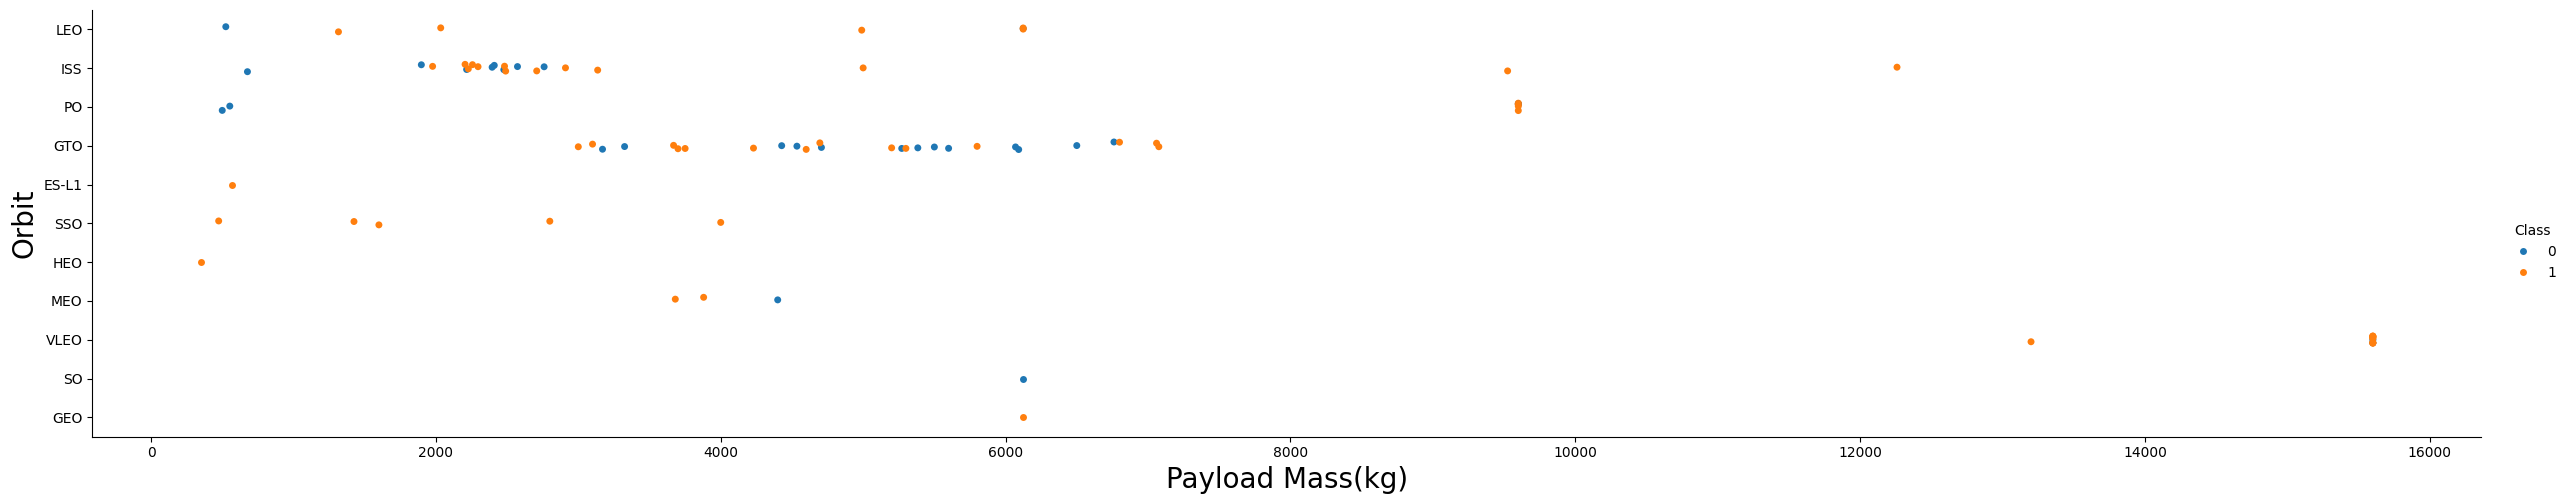

In [107]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("Payload Mass(kg)",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

In [108]:
orbit_success_rate = df.groupby('Orbit')['Class'].apply(lambda x: x.mean()).reset_index()
orbit_success_rate


,Orbit,Class
0,ES-L1,1.000000
1,GEO,1.000000
2,GTO,0.518519
3,HEO,1.000000
4,ISS,0.619048
5,LEO,0.714286
6,MEO,0.666667
7,PO,0.666667
8,SO,0.000000
9,SSO,1.000000


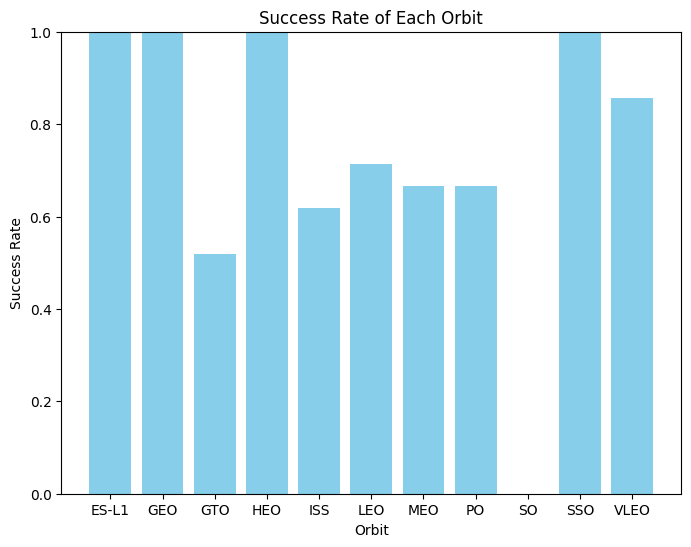

In [109]:
plt.figure(figsize=(8, 6))
plt.bar(orbit_success_rate['Orbit'], orbit_success_rate['Class'], color='skyblue')
plt.title('Success Rate of Each Orbit')
plt.xlabel('Orbit')
plt.ylabel('Success Rate')
plt.ylim(0, 1)  # Set y-axis limit to ensure it ranges from 0 to 1
plt.show()


In [110]:
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i[0:5])
    return year
Extract_year()
df['Date'] = year
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [111]:
year_success_rate = df.groupby('Date')['Class'].apply(lambda x: x.mean()).reset_index()
year_success_rate

,Date,Class
0,2010-,0.000000
1,2012-,0.000000
2,2013-,0.000000
3,2014-,0.333333
4,2015-,0.333333
5,2016-,0.625000
6,2017-,0.833333
7,2018-,0.611111
8,2019-,0.900000
9,2020-,0.842105


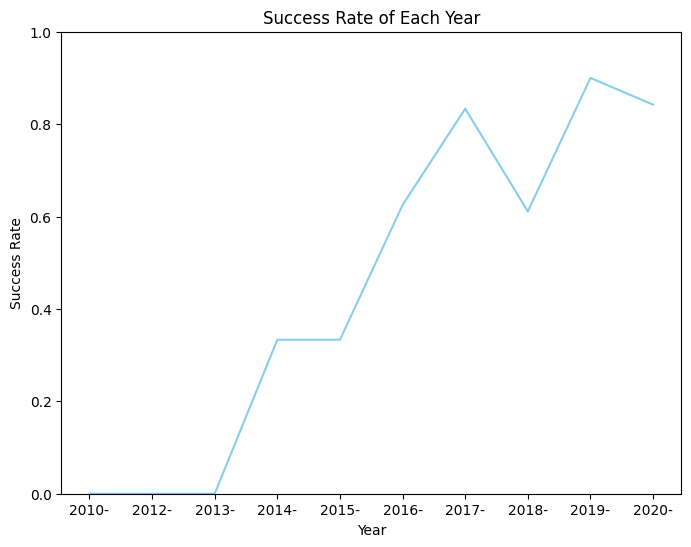

In [112]:
plt.figure(figsize=(8, 6))
plt.plot(year_success_rate['Date'], year_success_rate['Class'], color='skyblue')
plt.title('Success Rate of Each Year')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.ylim(0, 1)  # Set y-axis limit to ensure it ranges from 0 to 1
plt.show()

In [115]:
df_features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial','Class']]
df_features.tail()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Class
85,86,15600.0,VLEO,KSC LC 39A,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,1
86,87,15600.0,VLEO,KSC LC 39A,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,1
87,88,15600.0,VLEO,KSC LC 39A,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,1
88,89,15600.0,VLEO,CCSFS SLC 40,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,1
89,90,3681.0,MEO,CCSFS SLC 40,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,8,B1062,1


In [116]:
columns_to_encode = ['Orbit', 'LaunchSite', 'LandingPad', 'Serial']
encoded_df = pd.get_dummies(df_features, columns=columns_to_encode)
encoded_df.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [117]:
# List of numeric columns
numeric_columns = encoded_df.select_dtypes(include=['int64']).columns.tolist()

# Cast numeric columns to float64
encoded_df[numeric_columns] = encoded_df[numeric_columns].astype('float64')

encoded_df.head()


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2.0,525.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3.0,677.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4.0,500.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5.0,3170.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [118]:
encoded_df.shape

(90, 81)

In [133]:
encoded_df.to_csv('dataset_part_3.csv', index=False)

In [134]:
!pip install scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [135]:
df= pd.read_csv('dataset_part_3.csv')

In [136]:
df.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2.0,525.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3.0,677.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4.0,500.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5.0,3170.000000,1.0,False,False,False,1.0,0.0,0.0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [137]:
for col in df.columns:
    df[col] = df[col].astype(float)

In [138]:
df.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
df.shape

(90, 81)

In [140]:
df.columns

Index(['FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'Reused', 'Legs',
       'Block', 'ReusedCount', 'Class', 'Orbit_ES-L1', 'Orbit_GEO',
       'Orbit_GTO', 'Orbit_HEO', 'Orbit_ISS', 'Orbit_LEO', 'Orbit_MEO',
       'Orbit_PO', 'Orbit_SO', 'Orbit_SSO', 'Orbit_VLEO',
       'LaunchSite_CCSFS SLC 40', 'LaunchSite_KSC LC 39A',
       'LaunchSite_VAFB SLC 4E', 'LandingPad_5e9e3032383ecb267a34e7c7',
       'LandingPad_5e9e3032383ecb554034e7c9',
       'LandingPad_5e9e3032383ecb6bb234e7ca',
       'LandingPad_5e9e3032383ecb761634e7cb',
       'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B0003', 'Serial_B0005',
       'Serial_B0007', 'Serial_B1003', 'Serial_B1004', 'Serial_B1005',
       'Serial_B1006', 'Serial_B1007', 'Serial_B1008', 'Serial_B1010',
       'Serial_B1011', 'Serial_B1012', 'Serial_B1013', 'Serial_B1015',
       'Serial_B1016', 'Serial_B1017', 'Serial_B1018', 'Serial_B1019',
       'Serial_B1020', 'Serial_B1021', 'Serial_B1022', 'Serial_B1023',
       'Serial_B1025'

## train_test_split

In [157]:
X = df.drop(columns=['Class'])  # Assuming 'Class' is the target variable
y = df['Class'].to_numpy()
y = pd.Series(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [158]:
y_test.shape

(18,)

In [159]:
X_train.shape, X_test.shape

((72, 80), (18, 80))

# LOGISTIC REGRESSION

## Pipeline for Logistic Regression

In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression(max_iter=1000))])

In [165]:
param_grid_lr = {
    "logisticregression__C": [0.01, 0.1, 1],  # Note the prefix 'logisticregression__' for parameter C
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__solver": ['liblinear']
}

## Grid Search foR Logistic Regression

In [167]:
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=10)
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear']})

In [168]:
print("tuned hyperparameters: ", gs_lr.best_params_)
print("accuracy: ", gs_lr.best_score_)

tuned hyperparameters:  {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
accuracy:  0.8339285714285714


In [215]:
accuracy_lr = gs_lr.score(X_test, y_test)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8333333333333334


## Confusion Matrix for Logistic Regression

In [171]:
y_pred=gs_lr.predict(X_test)

In [196]:
def plot_confusion_matrix(y,y_pred):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

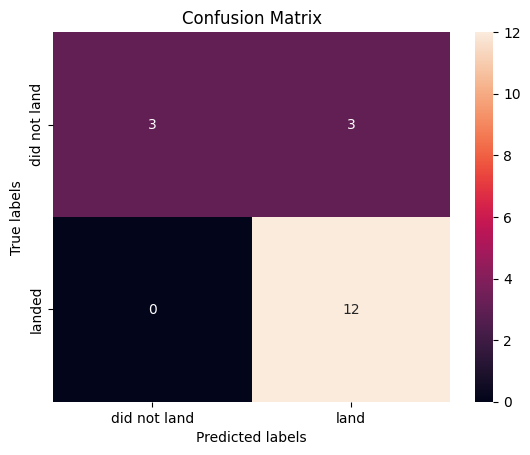

In [197]:
plot_confusion_matrix(y_test,y_pred)

# DECISION TREE

In [192]:
pipe_dt = Pipeline([('standardscaler', StandardScaler()), ('DecisionTree', DecisionTreeClassifier())])

param_grid_dt = {'DecisionTree__criterion': ['gini', 'entropy'],'DecisionTree__max_depth': [None, 5, 10, 20]}

gs_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=10)
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('DecisionTree',
                                        DecisionTreeClassifier())]),
             param_grid={'DecisionTree__criterion': ['gini', 'entropy'],
                         'DecisionTree__max_depth': [None, 5, 10, 20]})

In [193]:
print("tuned hyperparameters: ", gs_dt.best_params_)
print("accuracy: ", gs_dt.best_score_)

tuned hyperparameters:  {'DecisionTree__criterion': 'gini', 'DecisionTree__max_depth': None}
accuracy:  0.7910714285714286


In [217]:
accuracy_dt= gs_dt.score(X_test, y_test)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8333333333333334


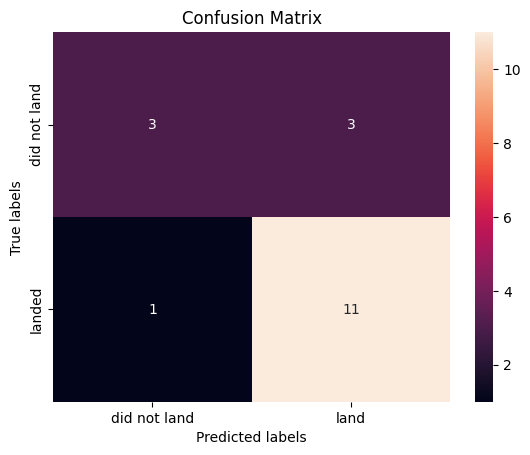

In [199]:
y_pred=gs_dt.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

# KNN 

In [202]:
pipe_knn = Pipeline([('standardscaler', StandardScaler()), ('knn', KNeighborsClassifier())])

param_grid_knn = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'knn__p': [1,2]}
gs_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=10)
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'knn__p': [1, 2]})

In [206]:
print("tuned hyperparameters: ", gs_knn.best_params_)
print("accuracy: ", gs_knn.best_score_)

tuned hyperparameters:  {'knn__algorithm': 'auto', 'knn__n_neighbors': 8, 'knn__p': 1}
accuracy:  0.8339285714285714


In [218]:
accuracy_knn = gs_knn.score(X_test, y_test)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8333333333333334


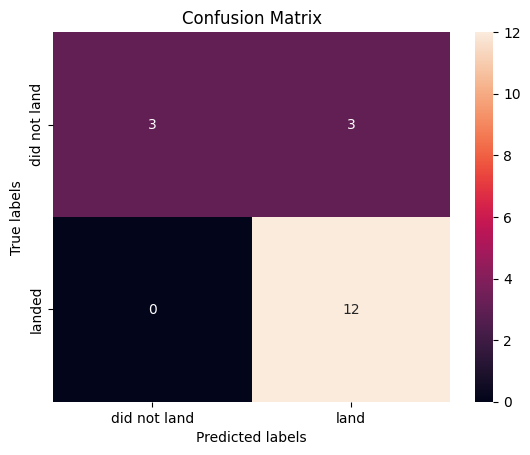

In [208]:
y_pred=gs_knn.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

# SVC

In [210]:
pipe_svc = Pipeline([('standardscaler', StandardScaler()), ('svc', SVC())])

param_grid_svc ={'svc__kernel':('linear', 'rbf','poly','rbf', 'sigmoid'), 'svc__C': np.logspace(-3, 3, 5), 'svc__gamma':np.logspace(-3, 3, 5)}
gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=10)
gs_svc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'svc__gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'svc__kernel': ('linear', 'rbf', 'poly', 'rbf',
                                         'sigmoid')})

In [211]:
print("tuned hyperparameters: ", gs_svc.best_params_)
print("accuracy: ", gs_svc.best_score_)

tuned hyperparameters:  {'svc__C': 1.0, 'svc__gamma': 0.03162277660168379, 'svc__kernel': 'sigmoid'}
accuracy:  0.8357142857142857


In [219]:
accuracy_svc = gs_svc.score(X_test, y_test)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8333333333333334


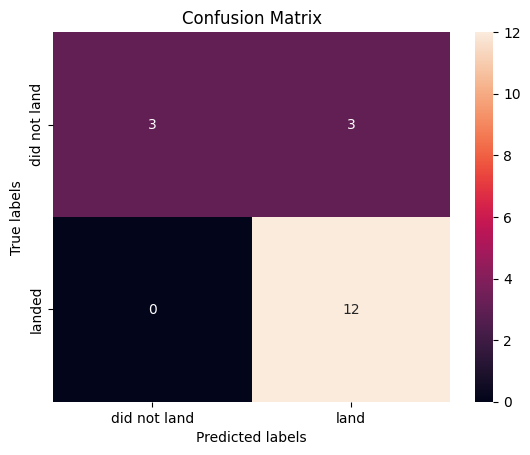

In [213]:
y_pred=gs_svc.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

In [229]:
print(f"lr accuracy score is: {accuracy_lr}, dt accuracy score is: {accuracy_dt}, knn accuracy score is: {accuracy_knn}, svc accurity score is: {accuracy_svc}")

lr accuracy score is: 0.8333333333333334, dt accuracy score is: 0.7777777777777778, knn accuracy score is: 0.8333333333333334, svc accurity score is: 0.8333333333333334
